# Dataset Preperation

In [9]:
!pip install albumentations

In [29]:
import albumentations as A
import cv2
import numpy as np
import os
from glob import glob
import random
import shutil

# Define augmentation pipeline
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.2)
])

# Load images from folder
image_paths = glob("/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/*.png") # Change path accordingly
save_folder = "/content/drive/MyDrive/Colab Notebooks/Model/augmented_images"
os.makedirs(save_folder, exist_ok=True)

# Augment and save images
for img_path in image_paths:
    img = cv2.imread(img_path)

    if img is None:
        print(f"Warning: Could not read image {img_path}")
        continue

    for i in range(10):
        augmented = augmentations(image=img)['image']
        filename = os.path.join(save_folder, f"{os.path.basename(img_path).split('.')[0]}_aug_{i}.png")

        print(f"Saving: {filename}")  # Debugging: Check if filenames are generated
        cv2.imwrite(filename, augmented)

print("Augmentation completed!")

# -------------------------------
# Include PNG images from another folder
# -------------------------------
drive_png_folder = "/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites"  # Change this to your PNG image folder

# Ensure the augmented images directory exists
os.makedirs(save_folder, exist_ok=True)

# Get all PNG images in the drive folder
png_images = [f for f in os.listdir(drive_png_folder) if f.endswith('.png')]

# Copy PNG images to augmented images folder
for img_name in png_images:
    src_path = os.path.join(drive_png_folder, img_name)
    dst_path = os.path.join(save_folder, img_name)
    shutil.copy(src_path, dst_path)

print(f"Added {len(png_images)} PNG images to the augmented folder.")


Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_0.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_1.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_2.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_3.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_4.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_5.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_6.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_7.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_8.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_9.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage1_aug_0.png
Saving: /

In [30]:
import json
import os
import cv2
import albumentations as A

# Define the path to your COCO JSON file
json_file_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/labels_my-project-name_2025-03-07-10-07-36.json"

# Load COCO JSON file
with open(json_file_path, "r") as f:
    coco_data = json.load(f)

# Define augmentation (must use bbox-compatible transformations)
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7)
], bbox_params=A.BboxParams(format='coco', label_fields=['category_id']))

# Create output folder for augmented images
os.makedirs("augmented_images", exist_ok=True)

new_images = []
new_annotations = []
new_image_id = max(img["id"] for img in coco_data["images"]) + 1
new_annotation_id = max(ann["id"] for ann in coco_data["annotations"]) + 1

# Process each image
for img_info in coco_data["images"]:
    img_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites", img_info["file_name"])  # Change to your actual image folder path
    img = cv2.imread(img_path)

    if img is None:
        print(f"Skipping {img_info['file_name']} (not found)")
        continue

    # Get annotations for this image
    ann_ids = [ann for ann in coco_data["annotations"] if ann["image_id"] == img_info["id"]]
    bboxes = [ann["bbox"] for ann in ann_ids]
    category_ids = [ann["category_id"] for ann in ann_ids]

    for i in range(10):  # Generate 10 augmented images per original
        # Apply augmentation
        augmented = augmentations(image=img, bboxes=bboxes, category_id=category_ids)

        # Save augmented image
        new_filename = img_info["file_name"].replace(".jpg", f"_aug_{i}.jpg").replace(".png", f"_aug_{i}.png")
        cv2.imwrite(os.path.join("augmented_images", new_filename), augmented["image"])

        # Add new image entry to COCO JSON
        new_img_info = img_info.copy()
        new_img_info["file_name"] = new_filename
        new_img_info["id"] = new_image_id
        new_images.append(new_img_info)

        # Add new annotations
        for j, ann in enumerate(ann_ids):
            new_ann = ann.copy()
            new_ann["id"] = new_annotation_id
            new_ann["bbox"] = augmented["bboxes"][j]
            new_ann["image_id"] = new_image_id
            new_annotations.append(new_ann)
            new_annotation_id += 1  # Increment annotation ID

        new_image_id += 1  # Increment image ID

# Update COCO JSON
coco_data["images"].extend(new_images)
coco_data["annotations"].extend(new_annotations)

# Save new COCO JSON
with open("/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels.json", "w") as f:
    json.dump(coco_data, f)

print("COCO annotations updated with augmented images!")


COCO annotations updated with augmented images!


**Testing if the annotations and images map correctly**

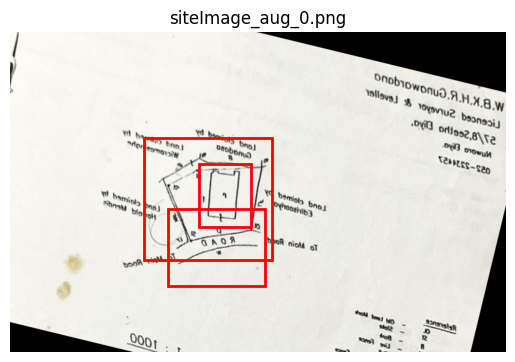

In [ ]:
import cv2
import matplotlib.pyplot as plt
import json
import os

# Load augmented COCO JSON file
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels.json', 'r') as f:
    coco_data = json.load(f)

# Pick one augmented image (look for '_aug_' in the filename)
aug_image_info = next((img for img in coco_data["images"] if "_aug_" in img["file_name"]), None)
if aug_image_info is not None:
    img_path = f"/content/augmented_images/{aug_image_info['file_name']}"
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] == aug_image_info["id"]]

        plt.imshow(img)
        ax = plt.gca()
        for ann in annotations:
            x, y, w, h = ann["bbox"]
            ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2))
        plt.title(aug_image_info['file_name'])
        plt.axis("off")
        plt.show()
    else:
        print(f"Augmented image not found at: {img_path}")
else:
    print("No augmented image entry found in JSON.")


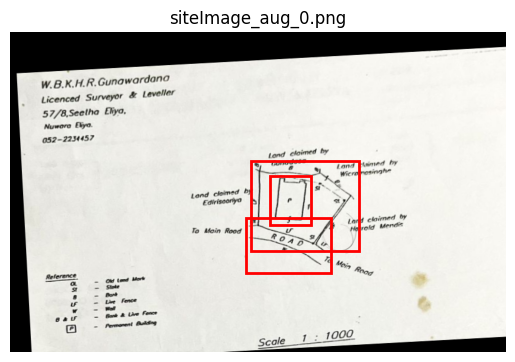

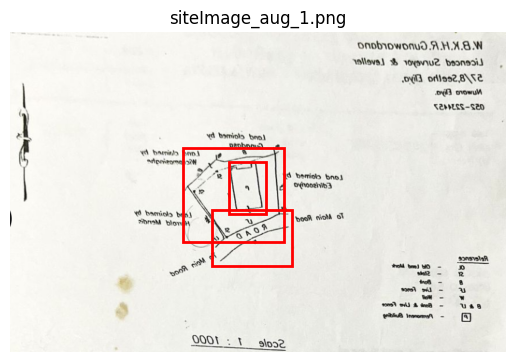

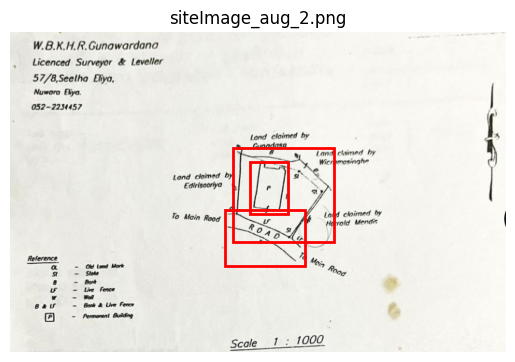

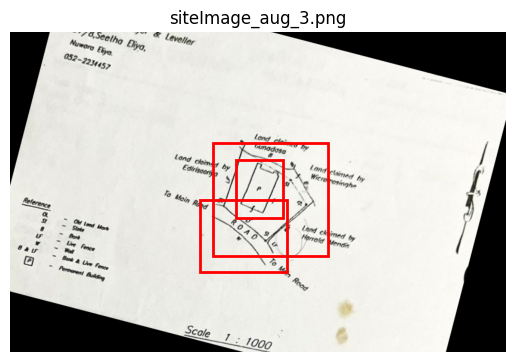

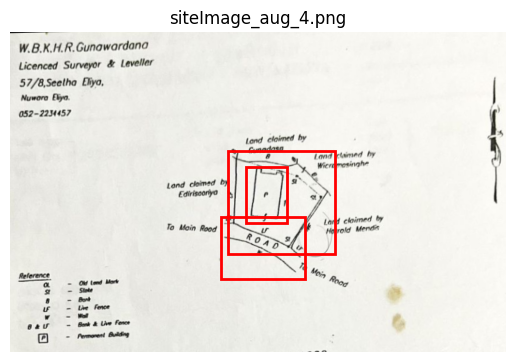

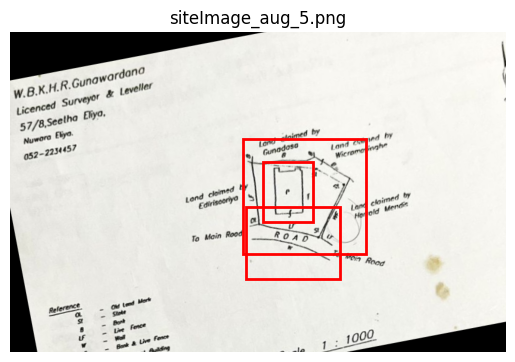

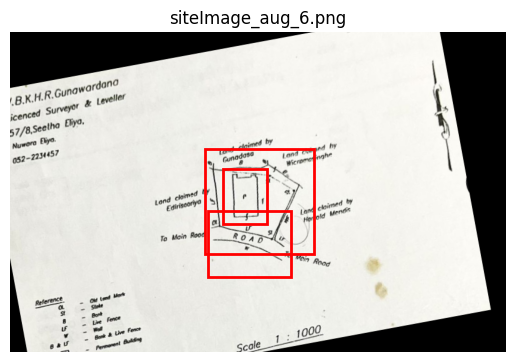

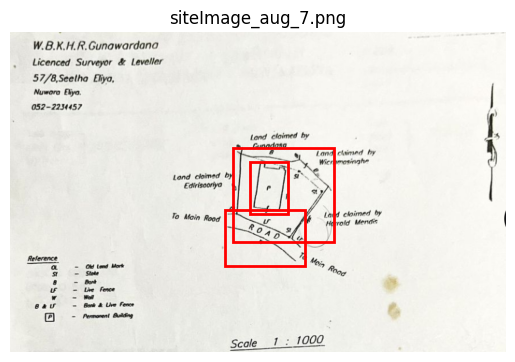

KeyboardInterrupt: 

In [ ]:
import cv2
import matplotlib.pyplot as plt
import json
import os

# Load augmented COCO JSON file
with open('/content//augmented_labels.json', 'r') as f:
    coco_data = json.load(f)

# Loop through the augmented images in the JSON and display them
for aug_image_info in coco_data["images"]:
    if "_aug_" in aug_image_info["file_name"]:  # Only show augmented images
        img_path = f"/content/augmented_images/{aug_image_info['file_name']}"

        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

            annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] == aug_image_info["id"]]

            # Plot image with bounding boxes
            plt.imshow(img)
            ax = plt.gca()
            for ann in annotations:
                x, y, w, h = ann["bbox"]
                ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2))

            plt.title(aug_image_info['file_name'])
            plt.axis("off")
            plt.show()
        else:
            print(f"Augmented image not found at: {img_path}")

In [10]:
!pip install opencv-python


# **Training The Model**

In [59]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Check if GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Assume you have 3 object classes plus background
num_classes = 1 + 3  # 1 background + 3 classes

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one (that has num_classes outputs)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the appropriate device
model.to(device)

print("Faster R-CNN model is set up and ready for training/fine-tuning!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Faster R-CNN model is set up and ready for training/fine-tuning!


In [28]:
import os
import shutil

# Define directories
directories = [
    "/content/drive/MyDrive/Colab Notebooks/Model/train_images",
    "/content/drive/MyDrive/Colab Notebooks/Model/val_images",
    "/content/drive/MyDrive/Colab Notebooks/Model/test_images"
]

# Function to delete all images in the given directories
def delete_all_images(dirs):
    for dir_path in dirs:
        if os.path.exists(dir_path):
            for file_name in os.listdir(dir_path):
                file_path = os.path.join(dir_path, file_name)
                if os.path.isfile(file_path):
                    os.remove(file_path)
            print(f"Deleted all images in: {dir_path}")
        else:
            print(f"Directory not found: {dir_path}")


# Run the function
delete_all_images(directories)


Deleted all images in: /content/drive/MyDrive/Colab Notebooks/Model/train_images
Deleted all images in: /content/drive/MyDrive/Colab Notebooks/Model/val_images
Deleted all images in: /content/drive/MyDrive/Colab Notebooks/Model/test_images


Total annotations: 132, Valid annotations after filtering: 90
Image ID remapping: {11: 1, 24: 2, 9: 3, 26: 4, 22: 5, 21: 6, 8: 7, 13: 8, 12: 9, 19: 10, 33: 11, 7: 12, 1: 13, 17: 14, 2: 15, 29: 16, 25: 17, 10: 18, 5: 19, 16: 20, 27: 21, 20: 22, 31: 23}
Total annotations: 132, Valid annotations after filtering: 21
Image ID remapping: {32: 1, 4: 2, 23: 3, 30: 4, 18: 5}
Total annotations: 132, Valid annotations after filtering: 21
Image ID remapping: {3: 1, 14: 2, 28: 3, 6: 4, 15: 5}
Splits created: Train images: 23, Val images: 5, Test images: 5
Images have been copied to their respective directories.


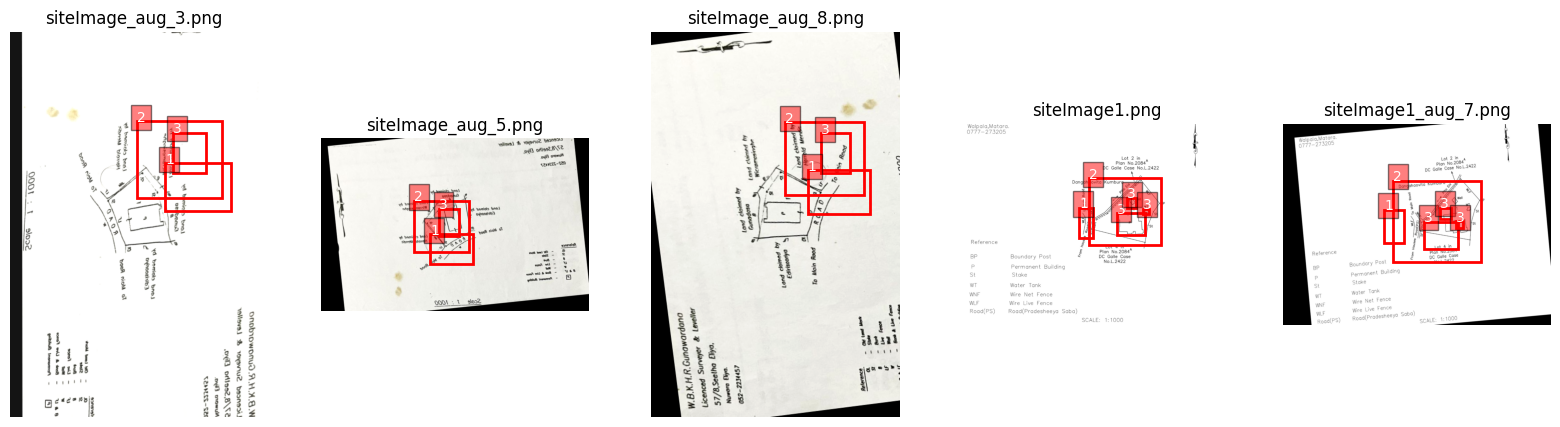

In [31]:
import os
import json
import random
import shutil
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# -------------------------------
# Paths: Update these if needed
# -------------------------------
original_json_path = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels.json'
original_images_dir = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_images'

# Output directories for splits
train_images_dir = '/content/drive/MyDrive/Colab Notebooks/Model/train_images'
val_images_dir   = '/content/drive/MyDrive/Colab Notebooks/Model/val_images'
test_images_dir  = '/content/drive/MyDrive/Colab Notebooks/Model/test_images'

# Create directories if they don't exist
for d in [train_images_dir, val_images_dir, test_images_dir]:
    os.makedirs(d, exist_ok=True)

# -------------------------------
# Load Original JSON and Split Images
# -------------------------------
with open(original_json_path, 'r') as f:
    coco_data = json.load(f)

# Get list of all images
all_images = coco_data["images"]
total = len(all_images)

# Optional: Shuffle images for random split order
random.shuffle(all_images)

# Calculate split indices (70% train, 15% val, 15% test)
train_end = int(0.7 * total)
val_end   = int(0.85 * total)

train_images = all_images[:train_end]
val_images   = all_images[train_end:val_end]
test_images  = all_images[val_end:]

# -------------------------------
# Filter and Remap Annotations for a Split
# -------------------------------
def filter_and_remap_split(original_data, split_images):
    # Get valid image IDs for this split
    valid_ids = {img["id"] for img in split_images}

    # Filter annotations that correspond to these images
    filtered_annotations = [ann for ann in original_data["annotations"] if ann["image_id"] in valid_ids]

    # Debugging: Print to ensure we're filtering correctly
    print(f"Total annotations: {len(original_data['annotations'])}, Valid annotations after filtering: {len(filtered_annotations)}")

    # Remap image IDs to sequential numbers (starting at 1)
    old_to_new = {}
    new_images = []
    for new_id, img in enumerate(split_images, start=1):
        old_to_new[img["id"]] = new_id
        new_img = img.copy()
        new_img["id"] = new_id
        new_images.append(new_img)

    # Debugging: Ensure old_to_new mapping is correct
    print(f"Image ID remapping: {old_to_new}")

    # Update annotations to point to the new image IDs
    new_annotations = []
    for ann in filtered_annotations:
        if ann["image_id"] in old_to_new:
            new_ann = ann.copy()
            new_ann["image_id"] = old_to_new[ann["image_id"]]  # Remap to new image ID
            new_annotations.append(new_ann)
        else:
            print(f"Annotation missing for image ID: {ann['image_id']}")  # Debugging missing annotations

    # Create a new JSON dict for this split.
    new_data = {
        "images": new_images,
        "annotations": new_annotations
    }

    # Include categories if available.
    if "categories" in original_data:
        new_data["categories"] = original_data["categories"]

    return new_data

train_data = filter_and_remap_split(coco_data, train_images)
val_data   = filter_and_remap_split(coco_data, val_images)
test_data  = filter_and_remap_split(coco_data, test_images)

# Save Fixed JSON Files for Each Split
train_json_path = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels_train.json'
val_json_path   = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels_val.json'
test_json_path  = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels_test.json'

with open(train_json_path, 'w') as f:
    json.dump(train_data, f)
with open(val_json_path, 'w') as f:
    json.dump(val_data, f)
with open(test_json_path, 'w') as f:
    json.dump(test_data, f)

print(f"Splits created: Train images: {len(train_data['images'])}, Val images: {len(val_data['images'])}, Test images: {len(test_data['images'])}")

# -------------------------------
# Copy Images into Their Respective Directories
# -------------------------------
def copy_images(image_list, src_dir, dst_dir):
    for img in image_list:
        src_path = os.path.join(src_dir, img["file_name"])
        dst_path = os.path.join(dst_dir, img["file_name"])
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Image not found: {src_path}")

copy_images(train_images, original_images_dir, train_images_dir)
copy_images(val_images, original_images_dir, val_images_dir)
copy_images(test_images, original_images_dir, test_images_dir)

print("Images have been copied to their respective directories.")

# -------------------------------
# Visualization Function
# -------------------------------
def visualize_images(data, image_dir, num_images=5):
    category_map = {cat["id"]: cat["name"] for cat in data["categories"]}
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    if num_images == 1:
        axes = [axes]  # Ensure iterable if only one image

    sampled_images = random.sample(data["images"], num_images)

    for ax, img_info in zip(axes, sampled_images):
        img_path = os.path.join(image_dir, img_info["file_name"])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.set_title(img_info["file_name"])
        ax.axis("off")

        # Plot bounding boxes
        for ann in data["annotations"]:
            if ann["image_id"] == img_info["id"]:
                bbox = ann["bbox"]
                x, y, w, h = bbox  # COCO format: [x, y, width, height]
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                label = category_map.get(ann["category_id"], "Unknown")
                ax.text(x, y, label, color='white', fontsize=10, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

# Run visualizations
visualize_images(train_data, train_images_dir, num_images=5)


In [60]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import json
import cv2
from torchvision import transforms
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, img_folder, ann_file, transform=None):
        """
        Initialize the dataset by loading the images and annotations.

        Args:
            img_folder (str): Path to the folder containing images.
            ann_file (str): Path to the annotation file (JSON).
            transform (callable, optional): A function/transform to apply on a sample.
        """
        self.img_folder = img_folder
        self.ann_file = ann_file
        self.transform = transform if transform else transforms.ToTensor()  # Default to ToTensor if no transform provided

        # Load the annotations
        with open(ann_file, 'r') as f:
            self.annotations = json.load(f)

    def __len__(self):
        """Return the number of images in the dataset."""
        return len(self.annotations["images"])

    def __getitem__(self, idx):
        """Get an image and its corresponding annotations."""
        img_info = self.annotations["images"][idx]
        img_path = os.path.join(self.img_folder, img_info["file_name"])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transformation (ToTensor) to image
        image = self.transform(image)

        # Get annotations for this image
        target = {"boxes": [], "labels": []}
        for ann in self.annotations["annotations"]:
            if ann["image_id"] == img_info["id"]:
                bbox = ann["bbox"]
                target["boxes"].append([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])  # [x_min, y_min, x_max, y_max]
                target["labels"].append(ann["category_id"])

        target["boxes"] = torch.tensor(target["boxes"], dtype=torch.float32)
        target["labels"] = torch.tensor(target["labels"], dtype=torch.int64)

        return image, target


In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

# Assuming CustomDataset class is already defined (as we discussed previously)
# Define your dataset
train_dataset = CustomDataset(img_folder='/content/train_images', ann_file='/content/augmented_labels_train.json', transform=None)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Use a pre-trained Faster R-CNN model from torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)

# Modify the model to fit your number of classes (assuming 91 for COCO, but adjust as necessary)
num_classes = 91  # COCO dataset has 80 classes + 1 background class
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, targets in progress_bar:
        # Move images and targets to device
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)

        # Total loss
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        # Backward pass
        losses.backward()

        # Update the weights
        optimizer.step()

        progress_bar.set_postfix(loss=losses.item())

    # Step the learning rate scheduler
    lr_scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {total_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'fasterrcnn.pth')

print("Training complete. Model saved to 'fasterrcnn.pth'.")


Epoch 1/5: 100%|██████████| 12/12 [09:31<00:00, 47.60s/it, loss=1.58]


Epoch 1/5, Total Loss: 22.5432


Epoch 2/5: 100%|██████████| 12/12 [09:21<00:00, 46.79s/it, loss=0.727]


Epoch 2/5, Total Loss: 10.1580


Epoch 3/5: 100%|██████████| 12/12 [09:25<00:00, 47.08s/it, loss=0.558]


Epoch 3/5, Total Loss: 6.2062


Epoch 4/5: 100%|██████████| 12/12 [09:21<00:00, 46.75s/it, loss=0.541]


Epoch 4/5, Total Loss: 4.8964


Epoch 5/5: 100%|██████████| 12/12 [09:23<00:00, 46.98s/it, loss=0.335]


Epoch 5/5, Total Loss: 3.7469
Training complete. Model saved to 'fasterrcnn.pth'.


In [79]:
import torch
import torchvision
from torchvision import models

# Initialize the model architecture
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)  # We don't want to load the pre-trained weights
num_classes = 91  # Adjust this based on the number of classes in your dataset (COCO has 91)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Load the model's weights from the file
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Model/fasterrcnn.pth'))

# Move the model to the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

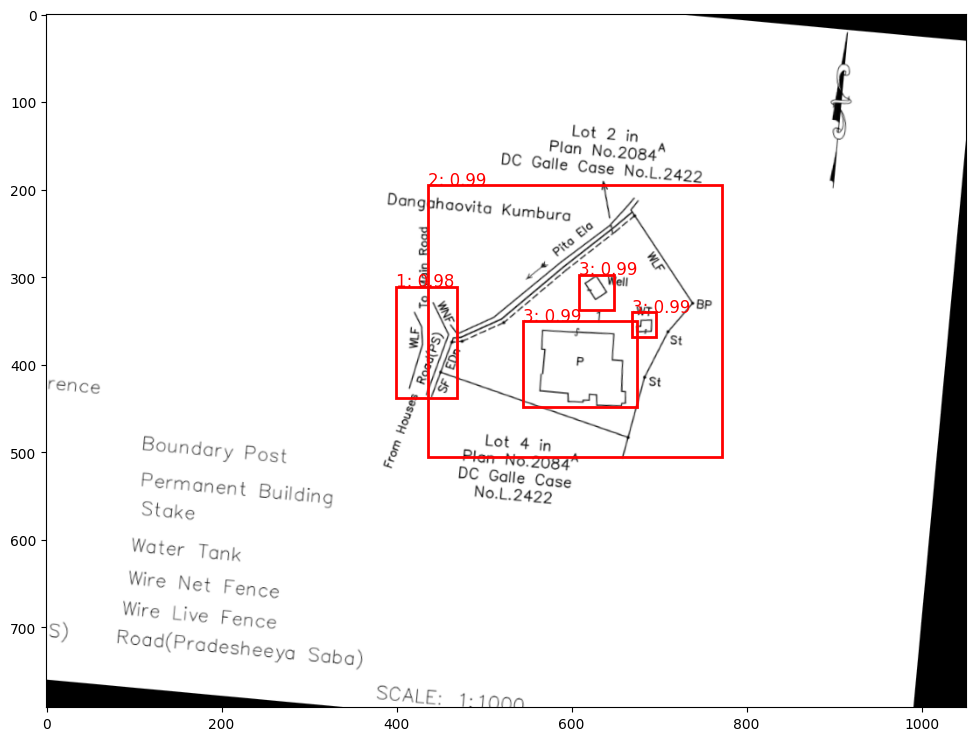

In [32]:
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image_path = '/content/test_images/siteImage1_aug_3.png'  # Replace with your image path
image = Image.open(image_path)

# Transform the image to the correct format
transform = T.Compose([
    T.ToTensor(),  # Convert the image to a tensor
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the image to the same device as the model
image_tensor = image_tensor.to(device)

# Run the image through the model
with torch.no_grad():
    prediction = model(image_tensor)

# The prediction is a list of dictionaries, where each dictionary corresponds to an image
# Each dictionary contains 'boxes', 'labels', and 'scores' keys
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Plot the image and draw bounding boxes
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(np.array(image))

# Loop over the predicted boxes and plot them
for i in range(len(boxes)):
    if scores[i] > 0.5:  # You can set a threshold for confidence score
        box = boxes[i]
        label = labels[i]
        score = scores[i]

        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], f'{label}: {score:.2f}', color='r', fontsize=12)

plt.show()


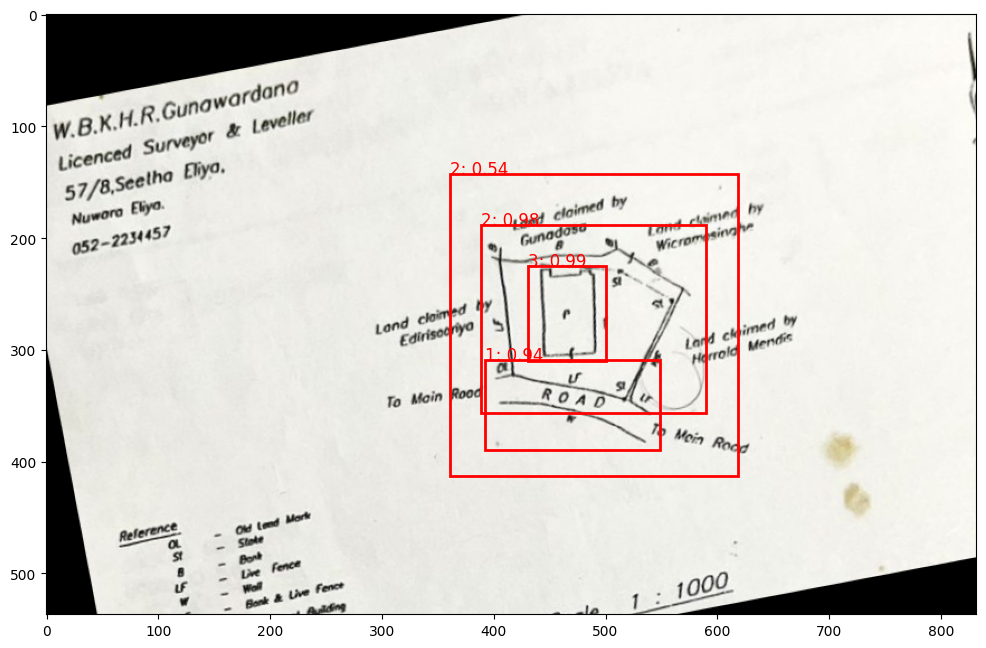

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image_path = '/content/test_images/siteImage_aug_5.png'  # Replace with your image path
image = Image.open(image_path)

# Transform the image to the correct format
transform = T.Compose([
    T.ToTensor(),  # Convert the image to a tensor
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Move the image to the same device as the model
image_tensor = image_tensor.to(device)

# Run the image through the model
with torch.no_grad():
    prediction = model(image_tensor)

# The prediction is a list of dictionaries, where each dictionary corresponds to an image
# Each dictionary contains 'boxes', 'labels', and 'scores' keys
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Plot the image and draw bounding boxes
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(np.array(image))

# Loop over the predicted boxes and plot them
for i in range(len(boxes)):
    if scores[i] > 0.5:  # You can set a threshold for confidence score
        box = boxes[i]
        label = labels[i]
        score = scores[i]

        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], f'{label}: {score:.2f}', color='r', fontsize=12)

plt.show()


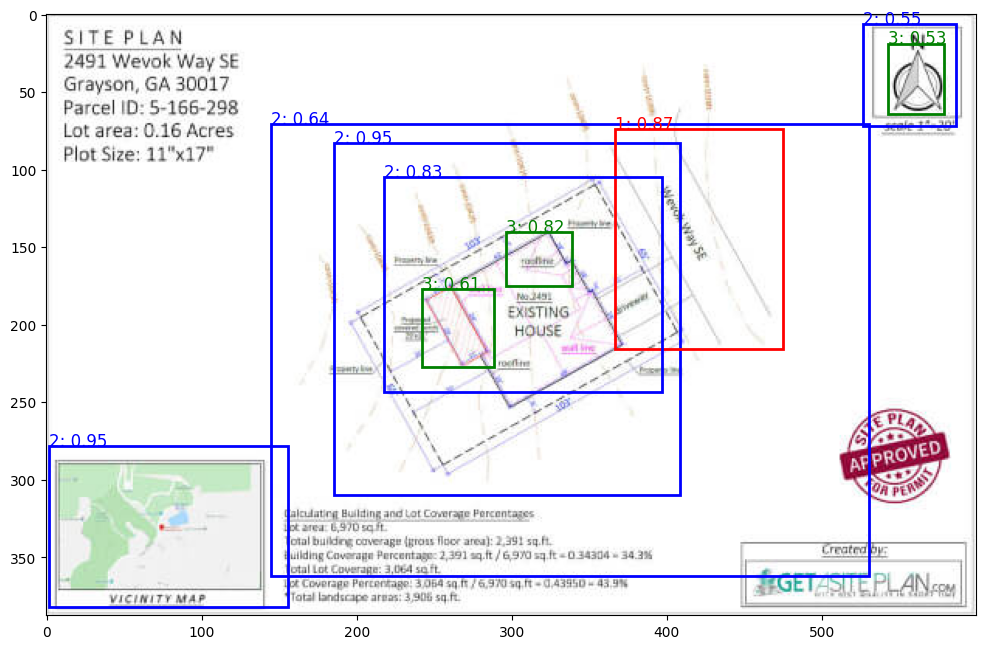

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image_path = '/content/plot-plan.jpg'  # Replace with your image path
image = Image.open(image_path)

# Transform the image to the correct format
transform = T.Compose([
    T.ToTensor(),  # Convert the image to a tensor
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Move the image to the same device as the model
image_tensor = image_tensor.to(device)

# Run the image through the model
with torch.no_grad():
    prediction = model(image_tensor)

# The prediction is a list of dictionaries, where each dictionary corresponds to an image
# Each dictionary contains 'boxes', 'labels', and 'scores' keys
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Define label colors (for example, mapping label IDs to colors)
label_colors = {
    1: 'red',     # Label type 1 (e.g., 'building') -> Red
    2: 'blue',    # Label type 2 (e.g., 'tree') -> Blue
    3: 'green'    # Label type 3 (e.g., 'vehicle') -> Green
}

# Plot the image and draw bounding boxes
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(np.array(image))

# Loop over the predicted boxes and plot them
for i in range(len(boxes)):
    if scores[i] > 0.5:  # You can set a threshold for confidence score
        box = boxes[i]
        label = labels[i]
        score = scores[i]

        # Get the color for the current label
        color = label_colors.get(label, 'yellow')  # Default to yellow if the label isn't in the dictionary

        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], f'{label}: {score:.2f}', color=color, fontsize=12)

plt.show()


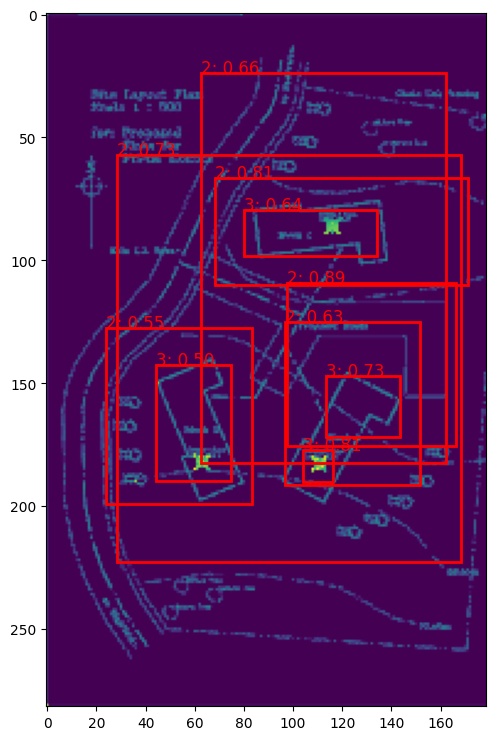

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image_path = '/content/testsite.png'  # Replace with your image path
image = Image.open(image_path)

# Transform the image to the correct format
transform = T.Compose([
    T.ToTensor(),  # Convert the image to a tensor
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Move the image to the same device as the model
image_tensor = image_tensor.to(device)

# Run the image through the model
with torch.no_grad():
    prediction = model(image_tensor)

# The prediction is a list of dictionaries, where each dictionary corresponds to an image
# Each dictionary contains 'boxes', 'labels', and 'scores' keys
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Plot the image and draw bounding boxes
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(np.array(image))

# Loop over the predicted boxes and plot them
for i in range(len(boxes)):
    if scores[i] > 0.5:  # You can set a threshold for confidence score
        box = boxes[i]
        label = labels[i]
        score = scores[i]

        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], f'{label}: {score:.2f}', color='r', fontsize=12)

plt.show()


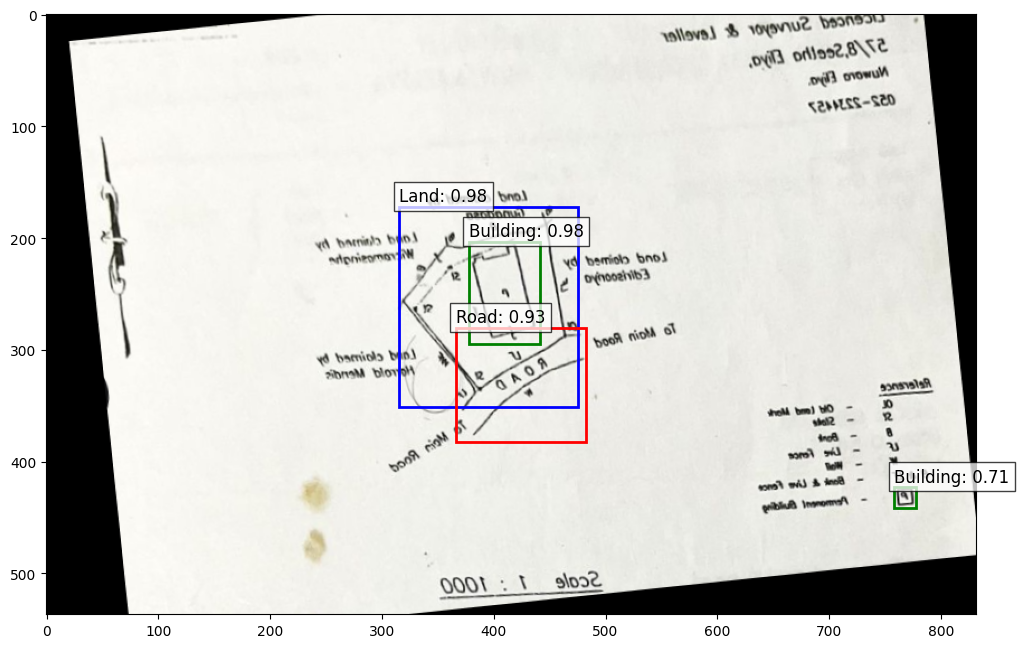

In [84]:
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image_path = '/content/drive/MyDrive/Colab Notebooks/Model/train_images/siteImage_aug_5.png'  # Replace with your image path
image = Image.open(image_path)

# Transform the image to the correct format
transform = T.Compose([
    T.ToTensor(),  # Convert the image to a tensor
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Move the image to the same device as the model
image_tensor = image_tensor.to(device)

# Run the image through the model
with torch.no_grad():
    prediction = model(image_tensor)

# Extract bounding boxes, labels, and scores
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Define label colors and names
label_colors = {
    1: 'red',   # Land
    2: 'blue',    # Road
    3: 'green'   # Building
}

label_names = {
    1: 'Road',
    2: 'Land',
    3: 'Building'
}

# Plot the image
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(np.array(image))

# Draw bounding boxes with labels
for i in range(len(boxes)):
    if scores[i] > 0.5:  # Confidence threshold
        box = boxes[i]
        label = labels[i]
        score = scores[i]

        # Get label color and name
        color = label_colors.get(label, 'yellow')  # Default to yellow if label is unknown
        label_text = label_names.get(label, 'Unknown')

        # Draw bounding box
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # Add text label
        ax.text(box[0], box[1] - 5, f'{label_text}: {score:.2f}', color='black', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.75))

plt.show()

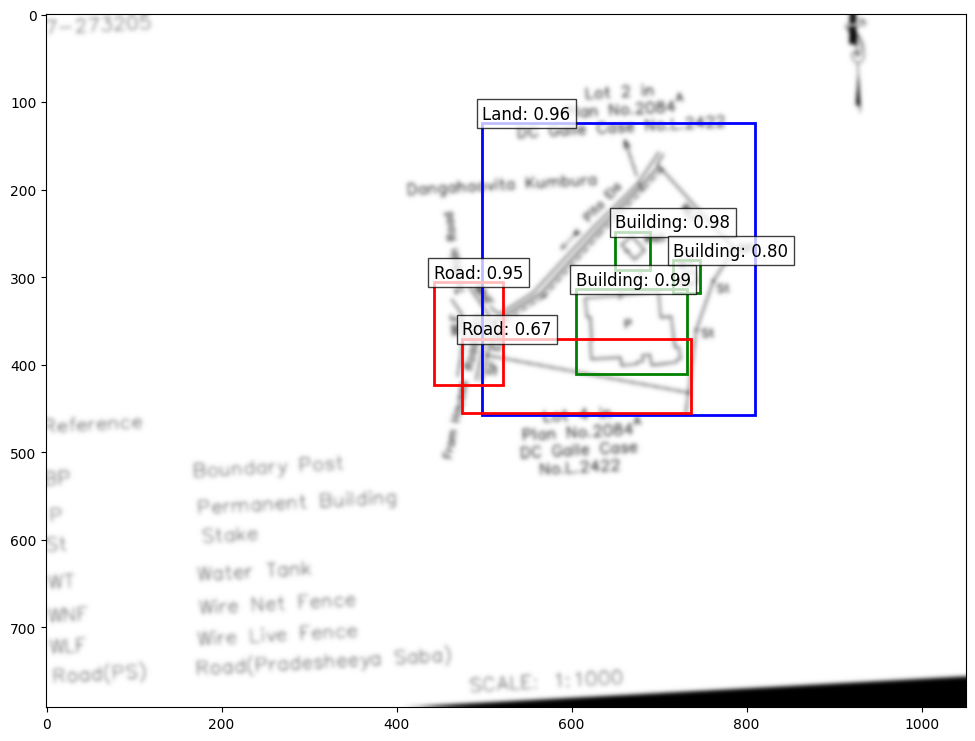

In [82]:
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image_path = '/content/drive/MyDrive/Colab Notebooks/Model/train_images/siteImage1_aug_3.png'  # Replace with your image path
image = Image.open(image_path)

# Transform the image to the correct format
transform = T.Compose([
    T.ToTensor(),  # Convert the image to a tensor
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Move the image to the same device as the model
image_tensor = image_tensor.to(device)

# Run the image through the model
with torch.no_grad():
    prediction = model(image_tensor)

# Extract bounding boxes, labels, and scores
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Define label colors and names
label_colors = {
    1: 'red',   # Land
    2: 'blue',    # Road
    3: 'green'   # Building
}

label_names = {
    1: 'Road',
    2: 'Land',
    3: 'Building'
}

# Plot the image
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(np.array(image))

# Draw bounding boxes with labels
for i in range(len(boxes)):
    if scores[i] > 0.5:  # Confidence threshold
        box = boxes[i]
        label = labels[i]
        score = scores[i]

        # Get label color and name
        color = label_colors.get(label, 'yellow')  # Default to yellow if label is unknown
        label_text = label_names.get(label, 'Unknown')

        # Draw bounding box
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # Add text label
        ax.text(box[0], box[1] - 5, f'{label_text}: {score:.2f}', color='black', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.75))

plt.show()

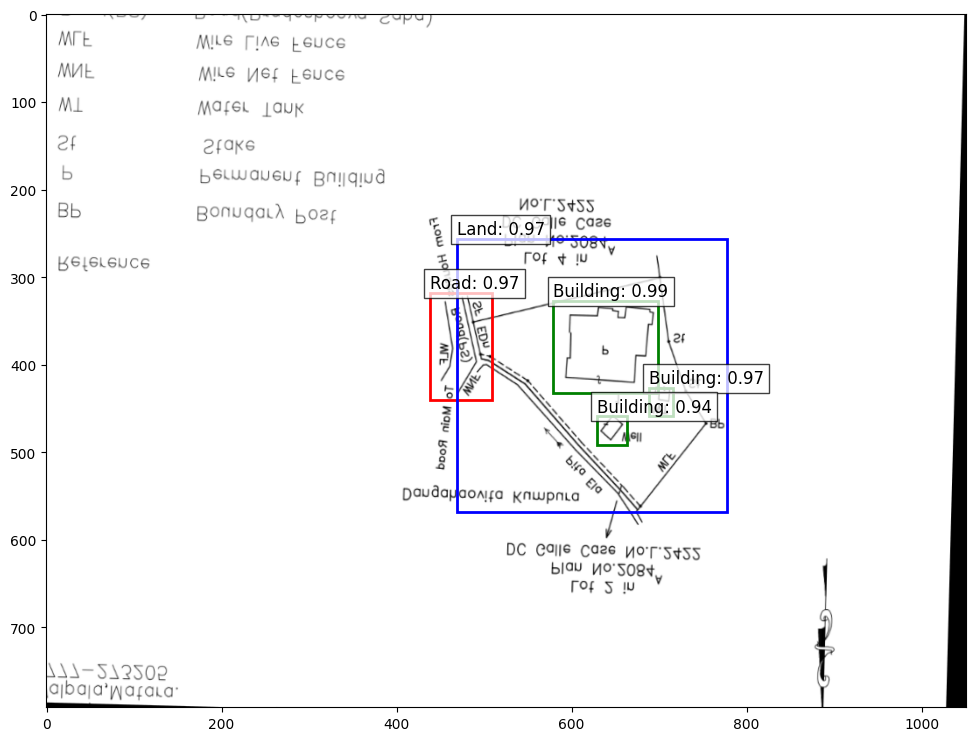

In [72]:
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image_path = '/content/drive/MyDrive/Colab Notebooks/Model/train_images/siteImage1_aug_6.png'  # Replace with your image path
image = Image.open(image_path)

# Transform the image to the correct format
transform = T.Compose([
    T.ToTensor(),  # Convert the image to a tensor
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Move the image to the same device as the model
image_tensor = image_tensor.to(device)

# Run the image through the model
with torch.no_grad():
    prediction = model(image_tensor)

# Extract bounding boxes, labels, and scores
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Define label colors and names
label_colors = {
    1: 'red',   # Land
    2: 'blue',    # Road
    3: 'green'   # Building
}

label_names = {
    1: 'Road',
    2: 'Land',
    3: 'Building'
}

# Plot the image
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(np.array(image))

# Draw bounding boxes with labels
for i in range(len(boxes)):
    if scores[i] > 0.5:  # Confidence threshold
        box = boxes[i]
        label = labels[i]
        score = scores[i]

        # Get label color and name
        color = label_colors.get(label, 'yellow')  # Default to yellow if label is unknown
        label_text = label_names.get(label, 'Unknown')

        # Draw bounding box
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # Add text label
        ax.text(box[0], box[1] - 5, f'{label_text}: {score:.2f}', color='black', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.75))

plt.show()

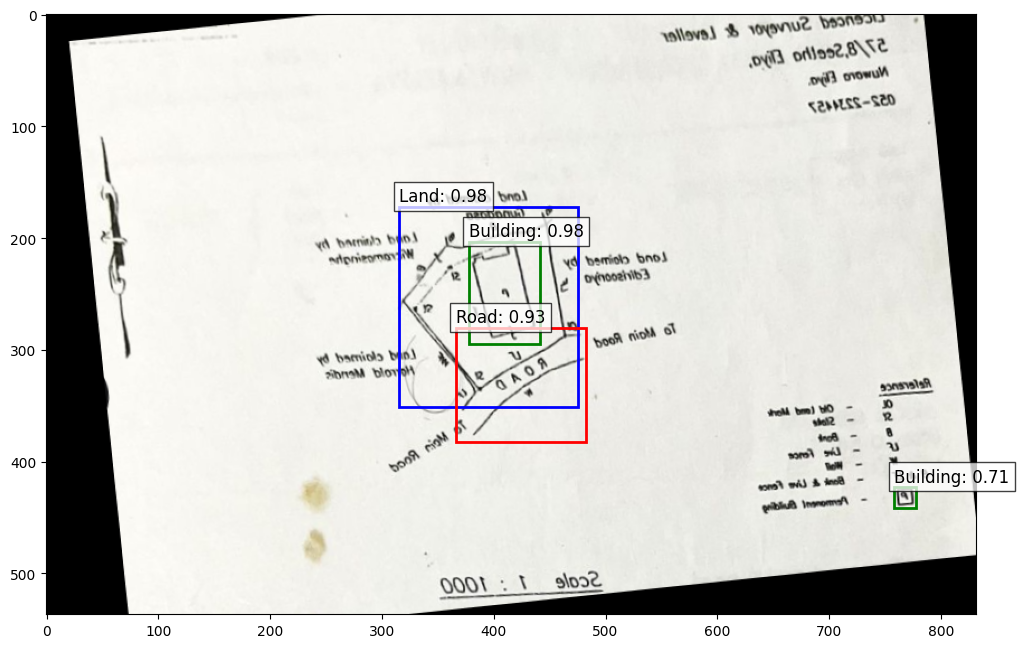

In [67]:
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image_path = '/content/drive/MyDrive/Colab Notebooks/Model/train_images/siteImage_aug_5.png'  # Replace with your image path
image = Image.open(image_path)

# Transform the image to the correct format
transform = T.Compose([
    T.ToTensor(),  # Convert the image to a tensor
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Move the image to the same device as the model
image_tensor = image_tensor.to(device)

# Run the image through the model
with torch.no_grad():
    prediction = model(image_tensor)

# Extract bounding boxes, labels, and scores
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Define label colors and names
label_colors = {
    1: 'red',   # Land
    2: 'blue',    # Road
    3: 'green'   # Building
}

label_names = {
    1: 'Road',
    2: 'Land',
    3: 'Building'
}

# Plot the image
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(np.array(image))

# Draw bounding boxes with labels
for i in range(len(boxes)):
    if scores[i] > 0.5:  # Confidence threshold
        box = boxes[i]
        label = labels[i]
        score = scores[i]

        # Get label color and name
        color = label_colors.get(label, 'yellow')  # Default to yellow if label is unknown
        label_text = label_names.get(label, 'Unknown')

        # Draw bounding box
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # Add text label
        ax.text(box[0], box[1] - 5, f'{label_text}: {score:.2f}', color='black', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.75))

plt.show()


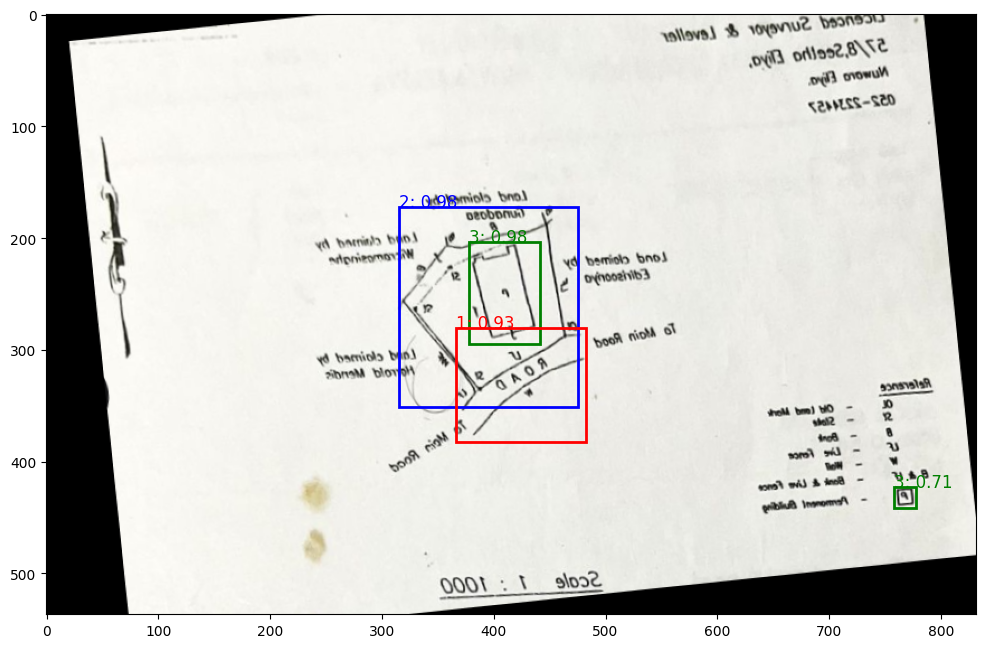

In [35]:
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image_path = '/content/drive/MyDrive/Colab Notebooks/Model/train_images/siteImage_aug_5.png'  # Replace with your image path
image = Image.open(image_path)

# Transform the image to the correct format
transform = T.Compose([
    T.ToTensor(),  # Convert the image to a tensor
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Move the image to the same device as the model
image_tensor = image_tensor.to(device)

# Run the image through the model
with torch.no_grad():
    prediction = model(image_tensor)

# The prediction is a list of dictionaries, where each dictionary corresponds to an image
# Each dictionary contains 'boxes', 'labels', and 'scores' keys
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Define label colors (for example, mapping label IDs to colors)
label_colors = {
    1: 'red',     # Label type 1 (e.g., 'building') -> Red
    2: 'blue',    # Label type 2 (e.g., 'tree') -> Blue
    3: 'green'    # Label type 3 (e.g., 'vehicle') -> Green
}

# Plot the image and draw bounding boxes
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(np.array(image))

# Loop over the predicted boxes and plot them
for i in range(len(boxes)):
    if scores[i] > 0.5:  # You can set a threshold for confidence score
        box = boxes[i]
        label = labels[i]
        score = scores[i]

        # Get the color for the current label
        color = label_colors.get(label, 'yellow')  # Default to yellow if the label isn't in the dictionary

        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], f'{label}: {score:.2f}', color=color, fontsize=12)

plt.show()


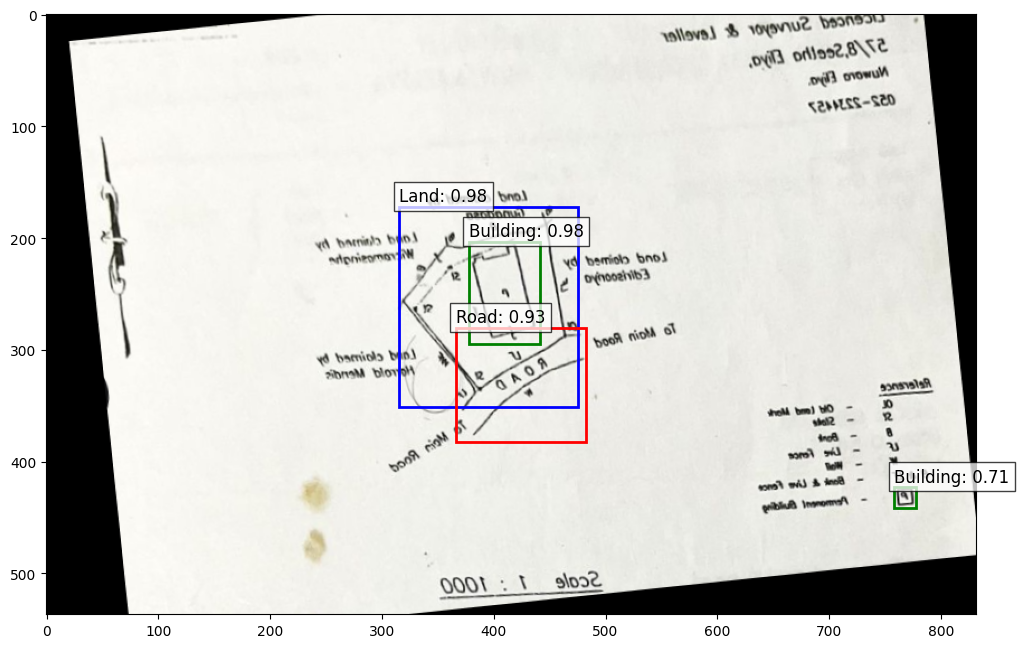

In [66]:
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image_path = '/content/drive/MyDrive/Colab Notebooks/Model/train_images/siteImage_aug_5.png'  # Replace with your image path
image = Image.open(image_path)

# Transform the image to the correct format
transform = T.Compose([
    T.ToTensor(),  # Convert the image to a tensor
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Move the image to the same device as the model
image_tensor = image_tensor.to(device)

# Run the image through the model
with torch.no_grad():
    prediction = model(image_tensor)

# Extract bounding boxes, labels, and scores
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Define label colors and names
label_colors = {
    1: 'red',   # Land
    2: 'blue',    # Road
    3: 'green'   # Building
}

label_names = {
    1: 'Road',
    2: 'Land',
    3: 'Building'
}

# Plot the image
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(np.array(image))

# Draw bounding boxes with labels
for i in range(len(boxes)):
    if scores[i] > 0.5:  # Confidence threshold
        box = boxes[i]
        label = labels[i]
        score = scores[i]

        # Get label color and name
        color = label_colors.get(label, 'yellow')  # Default to yellow if label is unknown
        label_text = label_names.get(label, 'Unknown')

        # Draw bounding box
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # Add text label
        ax.text(box[0], box[1] - 5, f'{label_text}: {score:.2f}', color='black', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.75))

plt.show()


In [ ]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 819.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [41]:
import torch
import json

# Path to your ground truth file
ground_truth_path = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels_test.json'

# Load the ground truth JSON file
with open(ground_truth_path, 'r') as f:
    ground_truth_data = json.load(f)

# Assuming 'annotations' contains the actual ground truth information
# If your format is different, adjust this part to extract boxes and labels
target = []

# Iterate through your ground truth data
for image_info in ground_truth_data['images']:
    image_id = image_info['id']

    # You would need to get the annotations related to this image
    annotations = [ann for ann in ground_truth_data['annotations'] if ann['image_id'] == image_id]

    boxes = []
    labels = []

    for ann in annotations:
        # If the bounding box is in [x, y, width, height], convert it to [x1, y1, x2, y2]
        x, y, w, h = ann['bbox']
        boxes.append([x, y, x + w, y + h])  # Convert to [x1, y1, x2, y2]
        labels.append(ann['category_id'])  # Replace with your actual category id if different

    target.append({
        "image_id": image_id,
        "boxes": torch.tensor(boxes, dtype=torch.float32),
        "labels": torch.tensor(labels, dtype=torch.int64)
    })

# Now 'target' contains the ground truth data in the correct format
print(target)


[{'image_id': 1, 'boxes': tensor([[116.4476,  84.6176, 272.4561, 275.3768],
        [162.1520, 224.6884, 321.8574, 266.8329],
        [235.6789, 121.9150, 298.4438, 148.5326],
        [165.8278, 129.0258, 494.8505, 429.7057]]), 'labels': tensor([1, 1, 1, 2])}, {'image_id': 2, 'boxes': tensor([[335.8887, 351.6095, 446.5816, 438.1663],
        [369.1798, 291.6855, 404.1355, 329.9702],
        [319.7309, 332.7282, 343.6322, 354.2394],
        [271.9186, 213.9969, 554.6035, 476.4176],
        [539.4053, 330.5157, 594.1185, 448.0478]]), 'labels': tensor([3, 3, 3, 2, 1])}, {'image_id': 3, 'boxes': tensor([[ 87.7057, 109.2923, 262.1638, 293.9242],
        [136.7799, 241.4630, 308.7887, 288.4402],
        [220.2228, 149.7746, 288.2553, 177.5623],
        [133.6951, 152.9193, 497.2589, 448.0470]]), 'labels': tensor([1, 1, 1, 2])}, {'image_id': 4, 'boxes': tensor([[276.8617, 163.7392, 464.8683, 348.3239],
        [323.9354, 280.4893, 470.8921, 392.0891],
        [360.3805, 194.9485, 432.7120, 29

In [48]:
import torch
import json
import os
from PIL import Image
import torchvision.transforms as T
import torchvision.models as models  # Import torchvision models

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Faster R-CNN model architecture
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)  # Load an untrained model
model_path = '/content/drive/MyDrive/Colab Notebooks/Model/fasterrcnn.pth'

# Load the trained weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # Set to evaluation mode

# Path to test images
test_image_dir = '/content/drive/MyDrive/Colab Notebooks/Model/test_images'

# Get list of image paths
test_image_paths = [
    os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

# Define image transformation
transform = T.Compose([T.ToTensor()])

# Minimum confidence threshold for filtering predictions
CONFIDENCE_THRESHOLD = 0.5

# Create a list to store predictions
predictions = []

# Loop through the test images
for img_path in test_image_paths:
    try:
        # Load and preprocess the image (convert to RGB to avoid channel mismatch)
        image = Image.open(img_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension & move to device

        # Run the image through the model
        with torch.no_grad():
            prediction = model(image_tensor)

        # Extract the necessary data
        boxes = prediction[0]['boxes'].cpu().numpy()  # Bounding box coordinates
        scores = prediction[0]['scores'].cpu().numpy()  # Confidence scores
        labels = prediction[0]['labels'].cpu().numpy()  # Class labels

        # Filter predictions based on confidence threshold
        valid_indices = scores >= CONFIDENCE_THRESHOLD
        filtered_boxes = boxes[valid_indices].tolist()
        filtered_scores = scores[valid_indices].tolist()
        filtered_labels = labels[valid_indices].tolist()

        # Create a dictionary for the current image if predictions exist
        if filtered_boxes:
            pred = {
                "image_id": os.path.basename(img_path),  # Use image filename as ID
                "boxes": filtered_boxes,
                "scores": filtered_scores,
                "labels": filtered_labels
            }
            predictions.append(pred)

    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# Save the predictions to a JSON file
output_predictions_file = '/content/drive/MyDrive/Colab Notebooks/Model/predictions.json'
with open(output_predictions_file, 'w') as f:
    json.dump(predictions, f, indent=4)

print(f"Predictions saved to {output_predictions_file}")


Predictions saved to /content/drive/MyDrive/Colab Notebooks/Model/predictions.json


In [55]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.7/931.7 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 834.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [57]:
import torch
import json
import torchmetrics.detection as detection_metrics

# Paths to ground truth and predictions
ground_truth_path = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels_test.json'
predictions_path = '/content/drive/MyDrive/Colab Notebooks/Model/predictions.json'

# Load ground truth JSON
with open(ground_truth_path, 'r') as f:
    ground_truth_data = json.load(f)

# Convert ground truth data to correct format
target = []
for image_info in ground_truth_data['images']:
    image_id = image_info['id']
    annotations = [ann for ann in ground_truth_data['annotations'] if ann['image_id'] == image_id]

    boxes, labels = [], []
    for ann in annotations:
        x, y, w, h = ann['bbox']
        boxes.append([x, y, x + w, y + h])  # Convert to [x1, y1, x2, y2]
        labels.append(ann['category_id'])  # Category IDs

    if boxes:  # Avoid empty tensors
        target.append({
            "image_id": image_id,
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
        })

# Load predictions JSON
with open(predictions_path, 'r') as f:
    preds_data = json.load(f)

# Convert predictions to correct format
preds = []
for pred in preds_data:
    image_id = pred["image_id"]
    boxes = torch.tensor(pred["boxes"], dtype=torch.float32)
    scores = torch.tensor(pred["scores"], dtype=torch.float32)
    labels = torch.tensor(pred["labels"], dtype=torch.int64)

    preds.append({
        "image_id": image_id,
        "boxes": boxes,
        "scores": scores,
        "labels": labels,
    })

# Ensure matching image IDs
target_image_ids = {item["image_id"] for item in target}
pred_image_ids = {item["image_id"] for item in preds}

common_ids = target_image_ids & pred_image_ids
print(f"Common image IDs: {common_ids}")

# Filter out mismatching entries
target = [item for item in target if item["image_id"] in common_ids]
preds = [item for item in preds if item["image_id"] in common_ids]

# Compute mAP
metric = detection_metrics.MeanAveragePrecision(iou_thresholds=[0.5, 0.75])
metric.update(preds, target)
result = metric.compute()

# Print results
print("mAP results:")
for key, value in result.items():
    value = value.item() if isinstance(value, torch.Tensor) and value.numel() == 1 else value.tolist()
    print(f"{key}: {value}")


Common image IDs: set()
mAP results:
map: -1.0
map_50: -1.0
map_75: -1.0
map_small: -1.0
map_medium: -1.0
map_large: -1.0
mar_1: -1.0
mar_10: -1.0
mar_100: -1.0
mar_small: -1.0
mar_medium: -1.0
mar_large: -1.0
classes: []


In [ ]:
!pip install pycocotools

In [85]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json

# Paths to your ground truth and predictions files
ground_truth_path = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels_test.json'
predictions_path = '/content/drive/MyDrive/Colab Notebooks/Model/predictions.json'

# Load ground truth annotations
coco_gt = COCO(ground_truth_path)

# Load predictions
with open(predictions_path, 'r') as f:
    preds = json.load(f)

# Inspect the image_ids in both ground truth and predictions
ground_truth_image_ids = set(coco_gt.getImgIds())
prediction_image_ids = set([pred['image_id'] for pred in preds])

print(f"Ground truth image IDs: {ground_truth_image_ids}")
print(f"Prediction image IDs: {prediction_image_ids}")

# If there are any discrepancies between image_ids, filter predictions to include only the matching ones
filtered_preds = [pred for pred in preds if pred['image_id'] in ground_truth_image_ids]

# Check if predictions are filtered correctly
print(f"Filtered {len(filtered_preds)} predictions out of {len(preds)}")

# If filtered_preds is empty, print more information
if len(filtered_preds) == 0:
    print("No predictions match ground truth image_ids. Double-check your prediction file.")
else:
    # Add filtered predictions to COCO format
    coco_dt = coco_gt.loadRes(filtered_preds)

    # Create a COCOeval object
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')

    # Run the evaluation
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Ground truth image IDs: {1, 2, 3, 4, 5}
Prediction image IDs: {'siteImage2.png', 'siteImage_aug_2.png', 'siteImage2_aug_4.png', 'siteImage1_aug_1.png', 'siteImage1_aug_0.png'}
Filtered 0 predictions out of 5
No predictions match ground truth image_ids. Double-check your prediction file.


In [87]:
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Paths to your prediction and ground truth files
predictions_path = '/content/drive/MyDrive/Colab Notebooks/Model/predictions.json'
ground_truth_path = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels_test.json'

# Load predictions
with open(predictions_path, 'r') as f:
    preds = json.load(f)

# Load ground truth annotations (if you want to overlay both ground truth and predictions)
with open(ground_truth_path, 'r') as f:
    ground_truth_data = json.load(f)

# Function to draw bounding boxes on the image
def draw_boxes(image_path, boxes, labels, colors=None):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    # Default color for bounding boxes
    if colors is None:
        colors = [(255, 0, 0)] * len(boxes)  # Red by default

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        color = colors[i]
        draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
        draw.text((x1, y1), str(labels[i]), fill=color)

    return image

# Display predictions on test images
for pred in preds:
    image_id = pred['image_id']
    boxes = pred['boxes']
    labels = pred['labels']

    # Try to find the image in ground truth data
    try:
        image_info = next(img for img in ground_truth_data['images'] if img['id'] == image_id)
        image_path = image_info['file_name']
    except StopIteration:
        # If the image is not found, print a warning and continue to the next prediction
        print(f"Warning: Image with id {image_id} not found in ground truth data. Skipping.")
        continue

    # Draw boxes and show the image
    image_with_boxes = draw_boxes(image_path, boxes, labels)

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.show()


# Print out all image_ids from ground truth and predictions
print("Ground truth image ids:")
ground_truth_image_ids = [img['id'] for img in ground_truth_data['images']]
print(ground_truth_image_ids)

print("\nPrediction image ids:")
prediction_image_ids = [pred['image_id'] for pred in preds]
print(prediction_image_ids)

# Find which image ids are missing in the ground truth data
missing_image_ids = set(prediction_image_ids) - set(ground_truth_image_ids)
print(f"\nMissing image ids in ground truth: {missing_image_ids}")


Ground truth image ids:
[1, 2, 3, 4, 5]

Prediction image ids:
['siteImage2.png', 'siteImage1_aug_0.png', 'siteImage2_aug_4.png', 'siteImage_aug_2.png', 'siteImage1_aug_1.png']

Missing image ids in ground truth: {'siteImage2.png', 'siteImage_aug_2.png', 'siteImage2_aug_4.png', 'siteImage1_aug_1.png', 'siteImage1_aug_0.png'}


In [88]:
# Update the image path to include the correct directory
image_directory = '/content/drive/MyDrive/Colab Notebooks/Model/test_images'  # Update this path to where your images are stored

# Function to draw bounding boxes on the image
def draw_boxes(image_path, boxes, labels, colors=None):
    image_path = image_directory + '/' + image_path  # Correct the path concatenation
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    # Default color for bounding boxes
    if colors is None:
        colors = [(255, 0, 0)] * len(boxes)  # Red by default

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        color = colors[i]
        draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
        draw.text((x1, y1), str(labels[i]), fill=color)

    return image

# Display predictions on test images
for pred in preds:
    image_id = pred['image_id']
    boxes = pred['boxes']
    labels = pred['labels']

    # Try to find the image in ground truth data
    try:
        image_info = next(img for img in ground_truth_data['images'] if img['id'] == image_id)
        image_path = image_info['file_name']
    except StopIteration:
        # If the image is not found, print a warning and continue to the next prediction
        print(f"Warning: Image with id {image_id} not found in ground truth data. Skipping.")
        continue

    # Draw boxes and show the image
    image_with_boxes = draw_boxes(image_path, boxes, labels)

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.show()
